##评分卡与集成学习

- 建立逻辑回归模型
- 对模型进行评分映射

### 逻辑回归回顾

- 公式

![](pics/lr1.jpg)

- 推导

![](pics/lr2.jpg)

![](pics/lr3.png)

![](pics/lr4.jpg)

### 逻辑回归构建评分卡

In [1]:

```python
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math
```

In [2]:

```python
data = pd.read_csv('Bcard.txt')
data.head()
```

Out[2]:

|      |    obs_mth | bad_ind |       uid | td_score | jxl_score | mj_score | rh_score | zzc_score | zcx_score | person_info | finance_info | credit_info | act_info |
| ---: | ---------: | ------: | --------: | -------: | --------: | -------: | -------: | --------: | --------: | ----------: | -----------: | ----------: | -------: |
|    0 | 2018-10-31 |     0.0 | A10000005 | 0.675349 |  0.144072 | 0.186899 | 0.483640 |  0.928328 |  0.369644 |   -0.322581 |     0.023810 |        0.00 | 0.217949 |
|    1 | 2018-07-31 |     0.0 |  A1000002 | 0.825269 |  0.398688 | 0.139396 | 0.843725 |  0.605194 |  0.406122 |   -0.128677 |     0.023810 |        0.00 | 0.423077 |
|    2 | 2018-09-30 |     0.0 |  A1000011 | 0.315406 |  0.629745 | 0.535854 | 0.197392 |  0.614416 |  0.320731 |    0.062660 |     0.023810 |        0.10 | 0.448718 |
|    3 | 2018-07-31 |     0.0 | A10000481 | 0.002386 |  0.609360 | 0.366081 | 0.342243 |  0.870006 |  0.288692 |    0.078853 |     0.071429 |        0.05 | 0.179487 |
|    4 | 2018-07-31 |     0.0 |  A1000069 | 0.406310 |  0.405352 | 0.783015 | 0.563953 |  0.715454 |  0.512554 |   -0.261014 |     0.023810 |        0.00 | 0.423077 |

In [3]:

```python
#看一下月份分布，我们用最后一个月做为跨时间验证集合
data.obs_mth.unique()
```

Out[3]:

```
array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)
```

In [4]:

```python
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()
```

In [5]:

```python
#这是我们全部的变量，info结尾的是自己做的无监督系统输出的个人表现，score结尾的是收费的外部征信数据
feature_lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']
```

In [6]:

```python
x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

lr_model = LogisticRegression(C=0.1)
lr_model.fit(x,y)
```

Out[6]:

```
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
```

#### 模型评价

- KS值
- ROC曲线

描绘的是不同的截断点时，并以FPR和TPR为横纵坐标轴，描述随着截断点的变小，TPR随着FPR的变化。
纵轴：TPR=正例分对的概率 = TP/(TP+FN)，其实就是查全率 召回
横轴：FPR=负例分错的概率 = FP/(FP+TN)    本来是0 咱们预测是1的样本在所有本来是0的样本中的概率

作图步骤：

根据学习器的预测结果（注意，是正例的概率值，非0/1变量）对样本进行排序（从大到小）-----这就是截断点依次选取的顺序 按顺序选取截断点，并计算TPR和FPR---也可以只选取n个截断点，分别在1/n，2/n，3/n等位置 连接所有的点（TPR，FPR）即为ROC图

#### KS值

作图步骤：

根据学习器的预测结果（注意，是正例的概率值，非0/1变量）对样本进行排序（从大到小）-----这就是截断点依次选取的顺序
按顺序选取截断点，并计算TPR和FPR ---也可以只选取n个截断点，分别在1/n，2/n，3/n等位置
横轴为样本的占比百分比（最大100%），纵轴分别为TPR和FPR，可以得到KS曲线
TPR和FPR曲线分隔最开的位置就是最好的”截断点“，最大间隔距离就是KS值，通常>0.2即可认为模型有比较好偶的预测准确性

In [7]:

```python
y_pred = lr_model.predict_proba(x)[:,1] #取出训练集预测值
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred) #计算TPR和FPR
train_ks = abs(fpr_lr_train - tpr_lr_train).max() #计算训练集KS
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1] #计算验证集预测值
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)   #计算验证集预测值
val_ks = abs(fpr_lr - tpr_lr).max()         #计算验证集KS值
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR') #绘制训练集ROC
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')               #绘制验证集ROC
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()
'''
train_ks :  0.4482453222991063
val_ks :  0.4198642457760936
'''
```



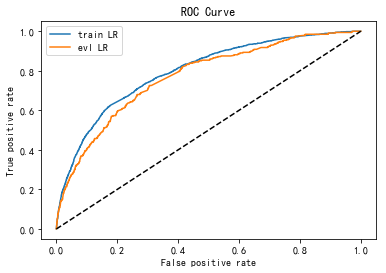

In [8]:

```python
#再做特征筛选  计算VIF值 方差膨胀系数
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = np.array(x)
for i in range(X.shape[1]):
    print(variance_inflation_factor(X,i))
1.3021397545577489
1.9579535743186598
1.2899442089163669
2.9681708673324287
3.2871099722760166
3.2864932840089116
3.3175087980337827
3.2910065791107583
```

In [9]:

```python
#使用lightgbm进行特征筛选
import lightgbm as lgb
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=0,test_size=0.2)
def  lgb_test(train_x,train_y,test_x,test_y):
    clf =lgb.LGBMClassifier(boosting_type = 'gbdt',
                           objective = 'binary',
                           metric = 'auc',
                           learning_rate = 0.1,
                           n_estimators = 24,
                           max_depth = 5,
                           num_leaves = 20,
                           max_bin = 45,
                           min_data_in_leaf = 6,
                           bagging_fraction = 0.6,
                           bagging_freq = 0,
                           feature_fraction = 0.8,
                           )
    clf.fit(train_x,train_y,eval_set = [(train_x,train_y),(test_x,test_y)],eval_metric = 'auc')
    return clf,clf.best_score_['valid_1']['auc'],
lgb_model , lgb_auc  = lgb_test(train_x,train_y,test_x,test_y)
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_}).sort_values(by=['importance'],ascending=False)
feature_importance
[1]	training's auc: 0.759467	valid_1's auc: 0.753322
[2]	training's auc: 0.809023	valid_1's auc: 0.805658
[3]	training's auc: 0.809328	valid_1's auc: 0.803858
[4]	training's auc: 0.810298	valid_1's auc: 0.801355
[5]	training's auc: 0.814873	valid_1's auc: 0.807356
[6]	training's auc: 0.816492	valid_1's auc: 0.809279
[7]	training's auc: 0.820213	valid_1's auc: 0.809208
[8]	training's auc: 0.823931	valid_1's auc: 0.812081
[9]	training's auc: 0.82696	valid_1's auc: 0.81453
[10]	training's auc: 0.827882	valid_1's auc: 0.813428
[11]	training's auc: 0.828881	valid_1's auc: 0.814226
[12]	training's auc: 0.829577	valid_1's auc: 0.813749
[13]	training's auc: 0.830406	valid_1's auc: 0.813156
[14]	training's auc: 0.830843	valid_1's auc: 0.812973
[15]	training's auc: 0.831587	valid_1's auc: 0.813501
[16]	training's auc: 0.831898	valid_1's auc: 0.813611
[17]	training's auc: 0.833751	valid_1's auc: 0.81393
[18]	training's auc: 0.834139	valid_1's auc: 0.814532
[19]	training's auc: 0.835177	valid_1's auc: 0.815209
[20]	training's auc: 0.837368	valid_1's auc: 0.815205
[21]	training's auc: 0.837946	valid_1's auc: 0.815099
[22]	training's auc: 0.839585	valid_1's auc: 0.815602
[23]	training's auc: 0.840781	valid_1's auc: 0.816105
[24]	training's auc: 0.841174	valid_1's auc: 0.816869
```

Out[9]:

|      | importance |         name |
| ---: | ---------: | -----------: |
|    2 |         98 |  credit_info |
|    3 |         62 |     act_info |
|    4 |         54 |     td_score |
|    5 |         50 |    jxl_score |
|    7 |         50 |     rh_score |
|    0 |         49 |  person_info |
|    1 |         47 | finance_info |
|    6 |         46 |     mj_score |

In [10]:

```python
#确定新的特征
feature_lst = ['person_info','finance_info','credit_info','act_info']
x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()
train_ks :  0.4482453222991063
val_ks :  0.4198642457760936
```

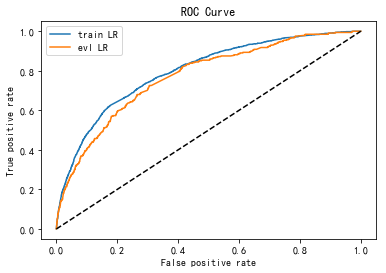

In [11]:

```python
# 系数
print('变量名单：',feature_lst)
print('系数：',lr_model.coef_)
print('截距：',lr_model.intercept_)
'''
变量名单： ['person_info', 'finance_info', 'credit_info', 'act_info']
系数： [[ 3.49460978 11.40051582  2.45541981 -1.68676079]]
截距： [-0.34484897]
'''
```

In [12]:

```python
#生成报告
model = lr_model
row_num, col_num = 0, 0
bins = 20 #分20箱
Y_predict = [s[1] for s in model.predict_proba(val_x)]
Y = val_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows/bins+1)# 计算每组有多少条数据
bad = sum([1 for (p, y) in ks_lis if y > 0.5]) # 计算逾期人数
good = sum([1 for (p, y) in ks_lis if y <= 0.5])   # 计算好人的人数
bad_cnt, good_cnt = 0, 0     # 累计坏人人数 ，累计好人的人数
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0.5])
    good1 = sum([1 for (p, y) in ds if y <= 0.5])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(val_y),3)  # 一箱一箱累加 到这一箱一共有多少逾期 占所有逾期的比例
    badrate = round(bad1/(bad1+good1),3)  # 一箱一箱累加 到这一箱一共有多少逾期占所有人的比例
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3) # 计算KS值
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot
```

Out[12]:

|      |  BAD | BADRATE | BAD_CNT | BAD_PCTG | GOOD | GOOD_CNT |    KS |
| ---: | ---: | ------: | ------: | -------: | ---: | -------: | ----: |
|    0 |   86 |   0.108 |      86 |    0.262 |  713 |      713 | 0.217 |
|    1 |   43 |   0.054 |     129 |    0.393 |  756 |     1469 | 0.299 |
|    2 |   29 |   0.036 |     158 |    0.482 |  770 |     2239 | 0.339 |
|    3 |   30 |   0.038 |     188 |    0.573 |  769 |     3008 | 0.381 |
|    4 |   22 |   0.028 |     210 |    0.640 |  777 |     3785 | 0.398 |
|    5 |   18 |   0.023 |     228 |    0.695 |  781 |     4566 | 0.403 |
|    6 |   18 |   0.023 |     246 |    0.750 |  781 |     5347 | 0.408 |
|    7 |   13 |   0.016 |     259 |    0.790 |  786 |     6133 | 0.398 |
|    8 |   16 |   0.020 |     275 |    0.838 |  783 |     6916 | 0.396 |
|    9 |    5 |   0.006 |     280 |    0.854 |  794 |     7710 | 0.361 |
|   10 |    7 |   0.009 |     287 |    0.875 |  792 |     8502 | 0.332 |
|   11 |    2 |   0.003 |     289 |    0.881 |  797 |     9299 | 0.287 |
|   12 |    7 |   0.009 |     296 |    0.902 |  792 |    10091 | 0.258 |
|   13 |    6 |   0.008 |     302 |    0.921 |  793 |    10884 | 0.225 |
|   14 |   11 |   0.014 |     313 |    0.954 |  788 |    11672 | 0.208 |
|   15 |    8 |   0.010 |     321 |    0.979 |  791 |    12463 | 0.182 |
|   16 |    2 |   0.003 |     323 |    0.985 |  797 |    13260 | 0.137 |
|   17 |    2 |   0.003 |     325 |    0.991 |  797 |    14057 | 0.092 |
|   18 |    1 |   0.001 |     326 |    0.994 |  798 |    14855 | 0.045 |
|   19 |    2 |   0.003 |     328 |    1.000 |  792 |    15647 | 0.000 |

In [16]:

```python
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()
```

Out[16]:

In [15]:

```python
#['person_info','finance_info','credit_info','act_info']
#算分数onekey 
def score(person_info,finance_info,credit_info,act_info):
    xbeta = person_info * ( 3.49460978) + finance_info * ( 11.40051582 ) + credit_info * (2.45541981) + act_info * ( -1.68676079) --0.34484897 
    score = 650-34* (xbeta)/math.log(2)  #  基准分+ 系数* 2^（1-p/p)
    return score
val['score'] = val.apply(lambda x : score(x.person_info,x.finance_info,x.credit_info,x.act_info) ,axis=1)

fpr_lr,tpr_lr,_ = roc_curve(val_y,val['score'])
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

#对应评级区间
def level(score):
    level = 0
    if score <= 600:
        level = "D"
    elif score <= 640 and score > 600 : 
        level = "C"
    elif score <= 680 and score > 640:
        level = "B"
    elif  score > 680 :
        level = "A"
    return level
val['level'] = val.score.map(lambda x : level(x) )

val.level.groupby(val.level).count()/len(val)
val_ks :  0.4198642457760936
```

Out[15]:

```
level
A    0.144351
B    0.240188
C    0.391299
D    0.224163
Name: level, dtype: float64
```

In [16]:

```python
import seaborn as sns
sns.distplot(val.score,kde=True)

val = val.sort_values('score',ascending=True).reset_index(drop=True)
df2=val.bad_ind.groupby(val['level']).sum()  # 每一组逾期的数量
df3=val.bad_ind.groupby(val['level']).count()   # 每一组一共有多少条记录
print(df2/df3)    
level
A    0.002168
B    0.008079
C    0.014878
D    0.055571
Name: bad_ind, dtype: float64
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
```

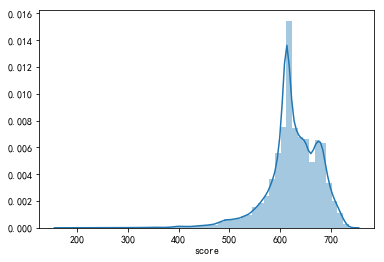

### Gradient Boosting算法

- 基本原理

  - 训练一个模型m1,产生错误e1
  - 针对e1训练一个模型m2,产生错误e2
  - 针对e2训练第三个模型m3,产生错误e3 .....
  - 最终预测结果是：m1+m2+m3+.....

  

  - GBDT是boosting的一种方法，主要思想:
    - 每一次建立单个分类器时，是在之前建立的模型的损失函数的梯度下降方向。
    - 损失函数越大，说明模型越容易出错，如果我们的模型能让损失函数持续的下降，则说明我们的模型在持续不断的改进，而最好的方式就是让损失函数在其梯度的方向上下降。
  - GBDT的核心在于每一棵树学的是之前所有树结论和的残差
    - 残差就是真实值与预测值的差值
    - 为了得到残差，GBDT中的树全部是回归树，不用分类树，分类的结果相减是没有意义的。
  - Shrinkage（缩减）是 GBDT 的一个重要演进分支
    - Shrinkage的思想在于每次走一小步来逼近真实的结果，比直接迈大步的方式好
    - Shrinkage可以有效减少过拟合的风险。它认为每棵树只学到了一小部分，累加的时候只累加这一小部分，通过多学习几棵树来弥补不足。这累加的一小部分（步长*残差）来逐步逼近目标，所以各个树的残差是渐变的而不是陡变的。
  - GBDT可以用于回归问题（线性和非线性），也可用于分类问题

  ![image-20191204022806221](pics\gbdt1.png)

- 对于高维稀疏特征不太适合用GBDT？
  - GBDT在每一次分割时需要比较大量的特征，特征太多，模型训练很耗费时间。
  - 树的分割往往只考虑了少部分特征，大部分的特征都用不到，所有的高维稀疏的特征会造成大量的特征浪费。

- GBDT和随机森林的异同点？
  - 相同点：
    - 都是由多棵树构成，最终的结果也是由多棵树决定。

  - 不同点：
    - 随机森林可以由分类树和回归树组成，GBDT只能由回归树组成。
    - 随机森林的树可以并行生成，而GBDT只能串行生成，所以随机森林的训练速度相对较快。
    - 随机森林关注减小模型的方差，GBDT关注减小模型的偏差。
    - 随机森林对异常值不敏感，GBDT对异常值非常敏感。
    - 随机森林最终的结果是多数投票或简单平均，而GBDT是加权累计起来。

- GBDT的优缺点？
  - 优点：
    - GBDT每一次的残差计算都增大了分错样本的权重，而分对的权重都趋近于0，因此泛化性能比较好。
    - 可以灵活的处理各种类型的数据。

  - 缺点：
    - 对异常值比较敏感。
    - 由于分类器之间存在依赖关系，所以很难进行并行计算。

### XGBOOST

- XGBOOST和GBDT的区别在哪里？
  - 传统的GBDT是以CART树作为基分类器，xgboost还支持线性分类器，这个时候xgboost相当于带L1和L2正则化项的逻辑回归（分类问题）或者线性回归（回归问题），线性分类器的速度是比较快的，这时候xgboost的速度优势就体现了出来。
  - 传统的GBDT在优化时只使用一阶导数，而xgboost对损失函数做了二阶泰勒展开，同时用到了一阶和二阶导数，并且xgboost支持使用自定义损失函数，只要损失函数可一阶，二阶求导。
  - 在损失函数里加入了正则项，用来减小模型的方差，防止过拟合，正则项里包含了树的叶节点的个数， 每个叶子节点上输出的score的L2模的平方和。
  - 有一个参数叫学习速率（learning_rate）
    -  xgboost在进行完一次迭代后，会将叶子节点的权重乘上学习速率，主要是为了削弱每棵树的影响，让后面有更大的学习空间
    - 实际应用中，一般把learing_rate设置得小一点，然后迭代次数(n_estimators)设置得大一点。
  - 借鉴了随机森林的原理，支持行抽样(subsample)和列抽样(colsample_bytree, colsample_bylevel)
    - 行抽样指的是随机森林里对数据集进行有放回抽样
    - 列抽样指的是对特征进行随机选择，不仅能降低过拟合，还能减少计算，这也是xgboost异于传统gbdt的一个特性。

- 为什么XGBOOST要用泰勒展开，优势在哪里？
  - gboost使用了一阶和二阶偏导，二阶导数有利于梯度下降的更快更准
  - 使用泰勒展开取得函数做自变量的二阶导数形式，可以在不选定损失函数具体形式的情况下，仅仅依靠输入数据的值就可以进行叶子分裂优化计算，本质上也就把损失函数的选取和模型算法的优化分开来了，这种去耦合增加了xgboost的适用性，使得它按需选取损失函数，既可以用于分类，也可以用于回归。

- XGBOOST是如何寻找最优特征的？
  - xgboost在训练过程中给出各个特征的增益评分，最大增益的特征会被选出来作为分裂依据，从而记忆了每个特征在模型训练时的重要性，从根到叶子中间节点涉及某特征的次数作为该特征重要性排序。

- XGBOOST是如何处理缺失值的？
  - xgboost为缺失值设定了默认的分裂方向，xgboost在树的构建过程中选择能够最小化训练误差的方向作为默认的分裂方向，即在训练时将缺失值划入左子树计算训练误差，再划入右子树计算训练误差，然后将缺失值划入误差小的方向。
- XGBOOST的并行化是如何实现的？
  - 并行不是在tree粒度上的并行，xgboost也是一次迭代完才能进行下一次迭代（第t次迭代的损失函数包含了第t-1次迭代的预测值）
  - 它的并行处理是在特征粒度上的，在决策树的学习中首先要对特征的值进行排序，然后找出最佳的分割点，xgboost在训练之前，就预先对数据做了排序， 然后保存为block结构，后面的迭代中重复地使用这个结构，大大减小计算量。这个block结构也使得并行成为了可能，在进行节点的分裂时，需要计算每个特征的增益，最终选增益最大的那个特征去做分裂，那么各个特征的增益计算就可以开多线程进行。
  - 可并行的近似直方图算法。树节点在进行分裂时，我们需要计算每个特征的每个分割点对应的增益，即用贪心法枚举所有可能的分割点。当数据无法一次载入内存或者在分布式情况下，贪心算法效率就会变得很低，所以xgboost还提出了一种可并行的近似直方图算法，用于高效地生成候选的分割点。

- XGBOOST采样时有放回的还是无放回的？
  - xgboost属于boosting方法的一种，所以采样时样本是不放回的，因而每轮计算样本不重复，另外，xgboost支持子采样，每轮计算可以不使用全部的样本，以减少过拟合。另外一点是xgboost还支持列采样，每轮计算按百分比随机抽取一部分特征进行训练，既可以提高速度又能减少过拟合。

#### xgboost 案例

#### .配合pandas DataFrame格式数据建模

In [8]:

```python
# 皮马印第安人糖尿病数据集 包含很多字段：怀孕次数 口服葡萄糖耐量试验中血浆葡萄糖浓度 舒张压（mm Hg） 三头肌组织褶厚度（mm） 
# 2小时血清胰岛素（μU/ ml） 体重指数（kg/（身高(m)^2） 糖尿病系统功能 年龄（岁）
import pandas as pd
data = pd.read_csv('Pima-Indians-Diabetes.csv')

'''
Pregnancies：怀孕次数 
Glucose：葡萄糖 
BloodPressure：血压 (mm Hg) 
SkinThickness：皮层厚度 (mm) 
Insulin：胰岛素 2小时血清胰岛素（mu U / ml 
BMI：体重指数 （体重/身高）^2 
DiabetesPedigreeFunction：糖尿病谱系功能 
Age：年龄 （岁） 
Outcome：类标变量 （0或1）
'''
data.head()
```

Out[8]:

|      | Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin |  BMI | DiabetesPedigreeFunction |  Age | Outcome |
| ---: | ----------: | ------: | ------------: | ------------: | ------: | ---: | -----------------------: | ---: | ------: |
|    0 |           6 |     148 |            72 |            35 |       0 | 33.6 |                    0.627 |   50 |       1 |
|    1 |           1 |      85 |            66 |            29 |       0 | 26.6 |                    0.351 |   31 |       0 |
|    2 |           8 |     183 |            64 |             0 |       0 | 23.3 |                    0.672 |   32 |       1 |
|    3 |           1 |      89 |            66 |            23 |      94 | 28.1 |                    0.167 |   21 |       0 |
|    4 |           0 |     137 |            40 |            35 |     168 | 43.1 |                    2.288 |   33 |       1 |

In [10]:

```python
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 转换成Dmatrix格式
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

#参数设定
param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 10
bst = xgb.train(param, xgtrain, num_round, watchlist)

# 使用模型预测
preds = bst.predict(xgtest)

# 判断准确率
labels = xgtest.get_label()
print ('错误类为%f' % \
       (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# 模型存储
bst.save_model('1.model')
[0]	eval-error:0.270833	train-error:0.234375
[1]	eval-error:0.234375	train-error:0.182292
[2]	eval-error:0.239583	train-error:0.170139
[3]	eval-error:0.229167	train-error:0.149306
[4]	eval-error:0.213542	train-error:0.147569
[5]	eval-error:0.234375	train-error:0.140625
[6]	eval-error:0.239583	train-error:0.147569
[7]	eval-error:0.255208	train-error:0.137153
[8]	eval-error:0.244792	train-error:0.140625
[9]	eval-error:0.244792	train-error:0.138889
错误类为0.244792
```

- 使用xgboost的sklearn包

In [12]:

```python
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# 用pandas读入数据
data = pd.read_csv('Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 取出特征X和目标y的部分
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
train_X = train[feature_columns].values
train_y = train[target_column].values
test_X = test[feature_columns].values
test_y = test[target_column].values

# 初始化模型
xgb_classifier = xgb.XGBClassifier(n_estimators=20,\
                                   max_depth=4, \
                                   learning_rate=0.1, \
                                   subsample=0.7, \
                                   colsample_bytree=0.7)

# 拟合模型
xgb_classifier.fit(train_X, train_y)
# 使用模型预测
preds = xgb_classifier.predict(test_X)
# 判断准确率
print ('错误类为%f' %((preds!=test_y).sum()/float(test_y.shape[0])))
# 模型存储
joblib.dump(xgb_classifier, '2.model')
错误类为0.229167
```

Out[12]:

```
['0003.model']
```

#### Xgboost建模，sklearn评估

In [16]:

```python
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)

#二分类：混淆矩阵
print("数字0和1的二分类问题")
digits = load_digits(2)
y = digits['target']
X = digits['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#多分类：混淆矩阵
print("\nIris: 多分类")
iris = load_iris()
y = iris['target']
X = iris['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#回归问题：MSE
print("\n波士顿房价回归预测问题")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("MSE:",mean_squared_error(actuals, predictions))

MSE: 15.989962572880902
```

- 网格搜索查找最优超参数

```python
# 第2种训练方法的 调参方法：使用sklearn接口的regressor + GridSearchCV
print("参数最优化：")
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
param_dict = {'max_depth': [2,4,6],
              'n_estimators': [50,100,200]}

clf = GridSearchCV(xgb_model, param_dict, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)
参数最优化：
Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.5984879606490934
{'max_depth': 4, 'n_estimators': 100}
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.7s finished
```

- early-stopping 早停:

```python
# 第1/2种训练方法的 调参方法：early stopping
# 在训练集上学习模型，一颗一颗树添加，在验证集上看效果，当验证集效果不再提升，停止树的添加与生长
X = digits['data']
y = digits['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_val, y_val)])
'''
[0]	validation_0-auc:0.999497
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999497
[2]	validation_0-auc:0.999497
[3]	validation_0-auc:0.999749
[4]	validation_0-auc:0.999749
[5]	validation_0-auc:0.999749
[6]	validation_0-auc:0.999749
[7]	validation_0-auc:0.999749
[8]	validation_0-auc:0.999749
[9]	validation_0-auc:0.999749
[10]	validation_0-auc:1
[11]	validation_0-auc:1
[12]	validation_0-auc:1
[13]	validation_0-auc:1
[14]	validation_0-auc:1
[15]	validation_0-auc:1
[16]	validation_0-auc:1
[17]	validation_0-auc:1
[18]	validation_0-auc:1
[19]	validation_0-auc:1
[20]	validation_0-auc:1
Stopping. Best iteration:
[10]	validation_0-auc:1
'''
```

Out[18]:

```
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
```

- 特征重要度

In [20]:

```python
iris = load_iris()
y = iris['target']
X = iris['data']
xgb_model = xgb.XGBClassifier().fit(X,y)

print('特征排序：')
feature_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for index in indices:
    print("特征 %s 重要度为 %f" %(feature_names[index], feature_importances[index]))

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title("feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], color='b')
特征排序：
特征 petal_length 重要度为 0.599222
特征 petal_width 重要度为 0.354334
特征 sepal_width 重要度为 0.034046
特征 sepal_length 重要度为 0.012397
```

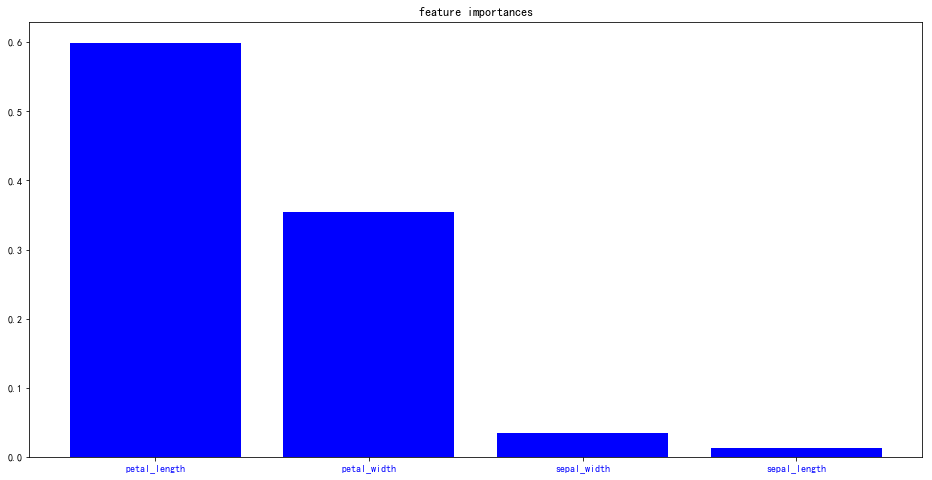

#### xgboost参数

- 选择较高的学习速率(learning rate)。一般情况下，学习速率的值为0.1。但是，对于不同的问题，理想的学习速率有时候会在0.05到0.3之间波动。选择对应于此学习速率的理想决策树数量。XGBoost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量。

- 对于给定的学习速率和决策树数量，进行决策树特定参数调优(max_depth, min_child_weight, gamma, subsample, colsample_bytree)。在确定一棵树的过程中，可以选择不同的参数

- xgboost的正则化参数的调优。(lambda, alpha)。这些参数可以降低模型的复杂度，从而提高模型的表现。

- 降低学习速率，确定理想参数。

#### Xgboost中可指定的参数，参数的详细说明如下

总共有3类参数：通用参数/general parameters, 集成(增强)参数/booster parameters 和 任务参数/task parameters

#### 通用参数/General Parameters

------

- booster [default=gbtree]
  - gbtree 和 gblinear
- silent [default=0]
  - 0表示输出信息， 1表示安静模式
- nthread
  - 跑xgboost的线程数，默认最大线程数
- num_pbuffer [无需用户手动设定]
  - size of prediction buffer, normally set to number of training instances. The buffers are used to save the prediction results of last boosting step.
- num_feature [无需用户手动设定]
  - feature dimension used in boosting, set to maximum dimension of the feature

#### 集成(增强)参数/booster parameters

- eta [default=0.3, 可以视作学习率]
  - 为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3
  - 取值范围为：[0,1]
- gamma [default=0, alias: min_split_loss]
  - 为了对树的叶子节点做进一步的分割而必须设置的损失减少的最小值，该值越大，算法越保守
  - range: [0,∞]
- max_depth [default=6]
  - 用于设置树的最大深度
  - range: [1,∞]
- min_child_weight [default=1]
  - 表示子树观测权重之和的最小值，如果树的生长时的某一步所生成的叶子结点，其观测权重之和小于min_child_weight，那么可以放弃该步生长，在线性回归模式中，这仅仅与每个结点所需的最小观测数相对应。该值越大，算法越保守
  - range: [0,∞]
- max_delta_step [default=0]
  - 如果该值为0，就是没有限制；如果设为一个正数，可以使每一步更新更加保守通常情况下这一参数是不需要设置的，但是在logistic回归的训练集中类极端不平衡的情况下，将这一参数的设置很有用，将该参数设为1-10可以控制每一步更新
  - range: [0,∞]
- subsample [default=1]
  - 表示观测的子样本的比率，将其设置为0.5意味着xgboost将随机抽取一半观测用于数的生长，这将有助于防止过拟合现象
  - range: (0,1]
- colsample_bytree [default=1]
  - 表示用于构造每棵树时变量的子样本比率
  - range: (0,1]
- colsample_bylevel [default=1]
  - 用来控制树的每一级的每一次分裂，对列数的采样的占比。一般不太用这个参数，因为subsample参数和colsample_bytree参数可以起到相同的作用。
  - range: (0,1]
- lambda [default=1, alias: reg_lambda]
  - L2 权重的L2正则化项
- alpha [default=0, alias: reg_alpha]
  - L1 权重的L1正则化项
- tree_method, string [default='auto']
  - The tree construction algorithm used in XGBoost(see description in the [reference paper](http://arxiv.org/abs/1603.02754))
  - Distributed and external memory version only support approximate algorithm.
  - Choices: {'auto', 'exact', 'approx'}
    - 'auto': Use heuristic to choose faster one.
      - For small to medium dataset, exact greedy will be used.
      - For very large-dataset, approximate algorithm will be chosen.
      - Because old behavior is always use exact greedy in single machine, user will get a message when approximate algorithm is chosen to notify this choice.
    - 'exact': Exact greedy algorithm.
    - 'approx': Approximate greedy algorithm using sketching and histogram.
- sketch_eps, [default=0.03]
  - This is only used for approximate greedy algorithm.
  - This roughly translated into `O(1 / sketch_eps)` number of bins. Compared to directly select number of bins, this comes with theoretical guarantee with sketch accuracy.
  - Usually user does not have to tune this. but consider setting to a lower number for more accurate enumeration.
  - range: (0, 1)
- scale_pos_weight, [default=1]
  - 在各类别样本十分不平衡时，把这个参数设定为一个正值，可以使算法更快收敛
  - 一个可以考虑的值: sum(negative cases) / sum(positive cases) see Higgs Kaggle competition demo for examples: [R](../demo/kaggle-higgs/higgs-train.R), [py1](../demo/kaggle-higgs/higgs-numpy.py), [py2](../demo/kaggle-higgs/higgs-cv.py), [py3](../demo/guide-python/cross_validation.py)
- updater, [default='grow_colmaker,prune']
  - A comma separated string defining the sequence of tree updaters to run, providing a modular way to construct and to modify the trees. This is an advanced parameter that is usually set automatically, depending on some other parameters. However, it could be also set explicitely by a user. The following updater plugins exist:
    - 'grow_colmaker': non-distributed column-based construction of trees.
    - 'distcol': distributed tree construction with column-based data splitting mode.
    - 'grow_histmaker': distributed tree construction with row-based data splitting based on global proposal of histogram counting.
    - 'grow_local_histmaker': based on local histogram counting.
    - 'grow_skmaker': uses the approximate sketching algorithm.
    - 'sync': synchronizes trees in all distributed nodes.
    - 'refresh': refreshes tree's statistics and/or leaf values based on the current data. Note that no random subsampling of data rows is performed.
    - 'prune': prunes the splits where loss < min_split_loss (or gamma).
  - In a distributed setting, the implicit updater sequence value would be adjusted as follows:
    - 'grow_histmaker,prune' when dsplit='row' (or default) and prob_buffer_row == 1 (or default); or when data has multiple sparse pages
    - 'grow_histmaker,refresh,prune' when dsplit='row' and prob_buffer_row < 1
    - 'distcol' when dsplit='col'
- refresh_leaf, [default=1]
  - This is a parameter of the 'refresh' updater plugin. When this flag is true, tree leafs as well as tree nodes' stats are updated. When it is false, only node stats are updated.
- process_type, [default='default']
  - A type of boosting process to run.
  - Choices: {'default', 'update'}
    - 'default': the normal boosting process which creates new trees.
    - 'update': starts from an existing model and only updates its trees. In each boosting iteration, a tree from the initial model is taken, a specified sequence of updater plugins is run for that tree, and a modified tree is added to the new model. The new model would have either the same or smaller number of trees, depending on the number of boosting iteratons performed. Currently, the following built-in updater plugins could be meaningfully used with this process type: 'refresh', 'prune'. With 'update', one cannot use updater plugins that create new nrees.

#### 任务参数/task parameters

- objective [ default=reg:linear ] 这个参数定义需要被最小化的损失函数。最常用的值有
  - "reg:linear" --线性回归
  - "reg:logistic" --逻辑回归
  - "binary:logistic" --二分类的逻辑回归，返回预测的概率(不是类别)
  - "binary:logitraw" --输出归一化前的得分
  - "count:poisson" --poisson regression for count data, output mean of poisson distribution
    - max_delta_step is set to 0.7 by default in poisson regression (used to safeguard optimization)
  - "multi:softmax" --设定XGBoost做多分类，你需要同时设定num_class(类别数)的值
  - "multi:softprob" --输出维度为ndata * nclass的概率矩阵
  - "rank:pairwise" --设定XGBoost去完成排序问题(最小化pairwise loss)
  - "reg:gamma" --gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be [gamma-distributed](https://en.wikipedia.org/wiki/Gamma_distribution#Applications)
  - "reg:tweedie" --Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be [Tweedie-distributed](https://en.wikipedia.org/wiki/Tweedie_distribution#Applications).
- base_score [ default=0.5 ]
  - the initial prediction score of all instances, global bias
  - for sufficient number of iterations, changing this value will not have too much effect.
- eval_metric [ 默认是根据 损失函数/目标函数 自动选定的 ]
  - 有如下的选择:
    - "rmse": [均方误差](http://en.wikipedia.org/wiki/Root_mean_square_error)
    - "mae": [绝对平均误差](https://en.wikipedia.org/wiki/Mean_absolute_error)
    - "logloss": negative [log损失](http://en.wikipedia.org/wiki/Log-likelihood)
    - "error": 二分类的错误率
    - "error@t": 通过提供t为阈值(而不是0.5)，计算错误率
    - "merror": 多分类的错误类，计算公式为#(wrong cases)/#(all cases).
    - "mlogloss": [多类log损失](https://www.kaggle.com/wiki/MultiClassLogLoss)
    - "auc": [ROC曲线下方的面积](http://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_curve) for ranking evaluation.
    - "ndcg":[Normalized Discounted Cumulative Gain](http://en.wikipedia.org/wiki/NDCG)
    - "map":[平均准确率](http://en.wikipedia.org/wiki/Mean_average_precision#Mean_average_precision)
    - "ndcg@n","map@n": n can be assigned as an integer to cut off the top positions in the lists for evaluation.
    - "ndcg-","map-","ndcg@n-","map@n-": In XGBoost, NDCG and MAP will evaluate the score of a list without any positive samples as 1. By adding "-" in the evaluation metric XGBoost will evaluate these score as 0 to be consistent under some conditions. training repeatedly
  - "poisson-nloglik": negative log-likelihood for Poisson regression
  - "gamma-nloglik": negative log-likelihood for gamma regression
  - "gamma-deviance": residual deviance for gamma regression
  - "tweedie-nloglik": negative log-likelihood for Tweedie regression (at a specified value of the tweedie_variance_power parameter)
- seed [ default=0 ]
  - random number seed.

### LightGBM

- 概念：LigthGBM是boosting集合模型中的新进成员，由微软提供，它和XGBoost一样是对GBDT的高效实现，原理上它和GBDT及XGBoost类似，都采用损失函数的负梯度作为当前决策树的残差近似值，去拟合新的决策树。

- LightGBM相比XGBOOST在原理和性能上的差异？

  1.速度和内存上的优化：

  - xgboost用的是预排序（pre-sorted）的方法， 空间消耗大
    - 这样的算法需要保存数据的特征值，还保存了特征排序的结果（例如排序后的索引，为了后续快速的计算分割点），这里需要消耗训练数据两倍的内存。 
    - 其次，时间上也有较大的开销，在遍历每一个分割点的时候，都需要进行分裂增益的计算，消耗的代价大。
  - LightGBM用的是直方图（Histogram）的决策树算法，直方图算法的基本思想是先把连续的浮点特征值离散化成k个整数，同时构造一个宽度为k的直方图。在遍历数据的时候，根据离散化后的值作为索引在直方图中累积统计量，当遍历一次数据后，直方图累积了需要的统计量，然后根据直方图的离散值，遍历寻找最优的分割点。

  2.准确率上的优化：

  - xgboost 通过level（depth）-wise策略生长树， Level-wise过一次数据可以同时分裂同一层的叶子，容易进行多线程优化，也好控制模型复杂度，不容易过拟合。但实际上Level-wise是一种低效的算法，因为它不加区分的对待同一层的叶子，带来了很多没必要的开销，因为实际上很多叶子的分裂增益较低，没必要进行搜索和分裂。
  - LightGBM通过leaf-wise（best-first）策略来生长树， Leaf-wise则是一种更为高效的策略，每次从当前所有叶子中，找到分裂增益最大的一个叶子，然后分裂，如此循环。因此同Level-wise相比，在分裂次数相同的情况下，Leaf-wise可以降低更多的误差，得到更好的精度。Leaf-wise的缺点是可能会长出比较深的决策树，产生过拟合。因此LightGBM在Leaf-wise之上增加了一个最大深度的限制，在保证高效率的同时防止过拟合。

  3.对类别型特征的处理**：**

  - xgboost不支持直接导入类别型变量，需要预先对类别型变量作亚编码等处理。如果类别型特征较多，会导致哑变量处理后衍生后的特征过多，学习树会生长的非常不平衡，并且需要非常深的深度才能来达到较好的准确率。
  - LightGBM可以支持直接导入类别型变量（导入前需要将字符型转为整数型，并且需要声明类别型特征的字段名），它没有对类别型特征进行独热编码，因此速度比独热编码快得多。LightGBM使用了一个特殊的算法来确定属性特征的分割值。基本思想是对类别按照与目标标签的相关性进行重排序，具体一点是对于保存了类别特征的直方图根据其累计值(sum_gradient/sum_hessian)重排序,在排序好的直方图上选取最佳切分位置。

#### LightGBM评分卡

```python
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math
import time
import lightgbm as lgb
data = pd.read_csv('Bcard.txt')
data.head()
```

Out[5]:

|      |    obs_mth | bad_ind |       uid | td_score | jxl_score | mj_score | rh_score | zzc_score | zcx_score | person_info | finance_info | credit_info | act_info |
| ---: | ---------: | ------: | --------: | -------: | --------: | -------: | -------: | --------: | --------: | ----------: | -----------: | ----------: | -------: |
|    0 | 2018-10-31 |     0.0 | A10000005 | 0.675349 |  0.144072 | 0.186899 | 0.483640 |  0.928328 |  0.369644 |   -0.322581 |     0.023810 |        0.00 | 0.217949 |
|    1 | 2018-07-31 |     0.0 |  A1000002 | 0.825269 |  0.398688 | 0.139396 | 0.843725 |  0.605194 |  0.406122 |   -0.128677 |     0.023810 |        0.00 | 0.423077 |
|    2 | 2018-09-30 |     0.0 |  A1000011 | 0.315406 |  0.629745 | 0.535854 | 0.197392 |  0.614416 |  0.320731 |    0.062660 |     0.023810 |        0.10 | 0.448718 |
|    3 | 2018-07-31 |     0.0 | A10000481 | 0.002386 |  0.609360 | 0.366081 | 0.342243 |  0.870006 |  0.288692 |    0.078853 |     0.071429 |        0.05 | 0.179487 |
|    4 | 2018-07-31 |     0.0 |  A1000069 | 0.406310 |  0.405352 | 0.783015 | 0.563953 |  0.715454 |  0.512554 |   -0.261014 |     0.023810 |        0.00 | 0.423077 |

In [3]:

```
data.shape
```

Out[3]:

```
(95806, 13)
```

In [4]:

```
#看一下月份分布，我们用最后一个月做为跨时间验证集合
data.obs_mth.unique()
```

Out[4]:

```
array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)
```

In [5]:

```python
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()
```

In [6]:

```python
#这是我们全部的变量，info结尾的是自己做的无监督系统输出的个人表现，score结尾的是收费的外部征信数据
lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']
```

In [7]:

```python
df_train = df_train.sort_values(by = 'obs_mth',ascending = False)
df_train.head()
```

Out[7]:

|       | index |    obs_mth | bad_ind |       uid | td_score | jxl_score | mj_score | rh_score | zzc_score | zcx_score | person_info | finance_info | credit_info | act_info |
| ----: | ----: | ---------: | ------: | --------: | -------: | --------: | -------: | -------: | --------: | --------: | ----------: | -----------: | ----------: | -------: |
|     0 |     0 | 2018-10-31 |     0.0 | A10000005 | 0.675349 |  0.144072 | 0.186899 | 0.483640 |  0.928328 |  0.369644 |   -0.322581 |     0.023810 |        0.00 | 0.217949 |
| 33407 | 33407 | 2018-10-31 |     0.0 |  A2810176 | 0.146055 |  0.079922 | 0.250568 | 0.045240 |  0.766906 |  0.413713 |    0.013863 |     0.023810 |        0.00 | 0.269231 |
| 33383 | 33383 | 2018-10-31 |     0.0 |  A2807687 | 0.551366 |  0.300781 | 0.225007 | 0.045447 |  0.735733 |  0.684182 |   -0.261014 |     0.071429 |        0.03 | 0.269231 |
| 33379 | 33379 | 2018-10-31 |     0.0 |  A2807232 | 0.708547 |  0.769513 | 0.928457 | 0.739716 |  0.947453 |  0.361551 |   -0.128677 |     0.047619 |        0.00 | 0.269231 |
| 33376 | 33376 | 2018-10-31 |     0.0 |  A2806932 | 0.482248 |  0.116658 | 0.286273 | 0.056618 |  0.047024 |  0.890433 |    0.078853 |     0.047619 |        0.00 | 0.269231 |

In [8]:

```python
df_train = df_train.sort_values(by = 'obs_mth',ascending = False)

rank_lst = []
for i in range(1,len(df_train)+1):
    rank_lst.append(i)
    
df_train['rank'] = rank_lst

df_train['rank'] = df_train['rank']/len(df_train)

pct_lst = []
for x in df_train['rank']:
    if x <= 0.2:
        x = 1
    elif x <= 0.4:
        x = 2
    elif x <= 0.6:
        x = 3
    elif x <= 0.8:
        x = 4
    else:
        x = 5
    pct_lst.append(x)
df_train['rank'] = pct_lst        
#train = train.drop('obs_mth',axis = 1)
df_train.head()
```

Out[8]:

|       | index |    obs_mth | bad_ind |       uid | td_score | jxl_score | mj_score | rh_score | zzc_score | zcx_score | person_info | finance_info | credit_info | act_info | rank |
| ----: | ----: | ---------: | ------: | --------: | -------: | --------: | -------: | -------: | --------: | --------: | ----------: | -----------: | ----------: | -------: | ---: |
|     0 |     0 | 2018-10-31 |     0.0 | A10000005 | 0.675349 |  0.144072 | 0.186899 | 0.483640 |  0.928328 |  0.369644 |   -0.322581 |      0.02381 |        0.00 | 0.217949 |    1 |
| 56822 | 56822 | 2018-10-31 |     0.0 |  A5492021 | 0.645511 |  0.058839 | 0.543122 | 0.235281 |  0.633456 |  0.186917 |   -0.053718 |      0.02381 |        0.10 | 0.166667 |    1 |
| 56991 | 56991 | 2018-10-31 |     0.0 |   A560974 | 0.299629 |  0.344316 | 0.500635 | 0.245191 |  0.056203 |  0.084314 |    0.078853 |      0.02381 |        0.03 | 0.538462 |    1 |
| 56970 | 56970 | 2018-10-31 |     0.0 |    A55912 | 0.929199 |  0.347249 | 0.438309 | 0.188931 |  0.611842 |  0.485462 |   -0.322581 |      0.02381 |        0.05 | 0.743590 |    1 |
| 57520 | 57520 | 2018-10-31 |     0.0 |   A601797 | 0.149059 |  0.803444 | 0.167015 | 0.264857 |  0.208072 |  0.704634 |   -0.261014 |      0.02381 |        0.00 | 0.525641 |    1 |

In [9]:

```
df_train['rank'].groupby(df_train['rank']).count()
```

Out[9]:

```
rank
1    15966
2    15966
3    15966
4    15966
5    15967
Name: rank, dtype: int64

```

In [10]:

```
len(df_train)
```

Out[10]:

```
79831
```

In [11]:

```python
#定义lgb函数
def LGB_test(train_x,train_y,test_x,test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=2, n_estimators=800,max_features = 140, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50,random_state=None,n_jobs=cpu_count()-1,
        num_iterations = 800 #迭代次数
    )
    clf.fit(train_x, train_y,eval_set=[(train_x, train_y),(test_x,test_y)],eval_metric='auc',early_stopping_rounds=100)
    print(clf.n_features_)

    return clf,clf.best_score_[ 'valid_1']['auc']
feature_lst = {}
ks_train_lst = []
ks_test_lst = []
for rk in set(df_train['rank']):   
    # 1，2，3，4，5
    # 测试集8.18以后作为跨时间验证集
    
    #定义模型训练集与测试集
    ttest = df_train[df_train['rank'] ==  rk]
    ttrain = df_train[df_train['rank'] !=  rk]
    
    train = ttrain[lst]
    train_y = ttrain.bad_ind
    
    test = ttest[lst]
    test_y = ttest.bad_ind    
    
    start = time.time()
    model,auc = LGB_test(train,train_y,test,test_y)                    
    end = time.time()
    
    #模型贡献度放在feture中
    feature = pd.DataFrame(
                {'name' : model.booster_.feature_name(),
                'importance' : model.feature_importances_
              }).sort_values(by =  ['importance'],ascending = False)
    
       
    #计算训练集、测试集、验证集上的KS和AUC

    y_pred_train_lgb = model.predict_proba(train)[:, 1]
    y_pred_test_lgb = model.predict_proba(test)[:, 1]


    train_fpr_lgb, train_tpr_lgb, _ = roc_curve(train_y, y_pred_train_lgb)
    test_fpr_lgb, test_tpr_lgb, _ = roc_curve(test_y, y_pred_test_lgb)


    train_ks = abs(train_fpr_lgb - train_tpr_lgb).max()
    test_ks = abs(test_fpr_lgb - test_tpr_lgb).max()


    train_auc = metrics.auc(train_fpr_lgb, train_tpr_lgb)
    test_auc = metrics.auc(test_fpr_lgb, test_tpr_lgb)
    
    ks_train_lst.append(train_ks)
    ks_test_lst.append(test_ks)    

    feature_lst[str(rk)] = feature[feature.importance>=20].name

train_ks = np.mean(ks_train_lst)
test_ks = np.mean(ks_test_lst)

ft_lst = {}
for i in range(1,6):
    ft_lst[str(i)] = feature_lst[str(i)]

fn_lst=list(set(ft_lst['1']) & set(ft_lst['2']) 
    & set(ft_lst['3']) & set(ft_lst['4']) &set(ft_lst['5']))

print('train_ks: ',train_ks)
print('test_ks: ',test_ks)

print('ft_lst: ',fn_lst )
8
train_ks:  0.49076511891289665
test_ks:  0.4728837205200532
ft_lst:  ['person_info', 'finance_info', 'act_info', 'credit_info']
```

In [13]:

```python
lst = ['person_info','finance_info','credit_info','act_info']

train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
evl = data[data.obs_mth == '2018-11-30'].reset_index().copy()

x = train[lst]
y = train['bad_ind']

evl_x =  evl[lst]
evl_y = evl['bad_ind']

model,auc = LGB_test(x,y,evl_x,evl_y)

y_pred = model.predict_proba(x)[:,1]
fpr_lgb_train,tpr_lgb_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lgb_train - tpr_lgb_train).max()
print('train_ks : ',train_ks)

y_pred = model.predict_proba(evl_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(evl_y,y_pred)
evl_ks = abs(fpr_lgb - tpr_lgb).max()
print('evl_ks : ',evl_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lgb_train,tpr_lgb_train,label = 'train LR')
plt.plot(fpr_lgb,tpr_lgb,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

4
train_ks :  0.4801091876625077
evl_ks :  0.4416674980164514
```

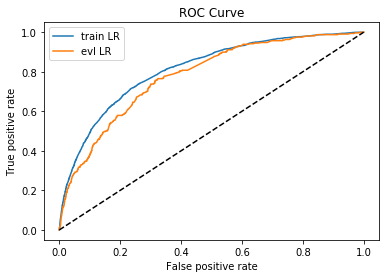

LightGBM其实效果确实是比较LR要好的

In [14]:

```python
#['person_info','finance_info','credit_info','act_info']
#算分数onekey 
def score(xbeta):
    score = 1000-500*(math.log2(1-xbeta)/xbeta)  #好人的概率/坏人的概率
    return score
evl['xbeta'] = model.predict_proba(evl_x)[:,1]   
evl['score'] = evl.apply(lambda x : score(x.xbeta) ,axis=1)
```

In [15]:

```python
fpr_lr,tpr_lr,_ = roc_curve(evl_y,evl['score'])
evl_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',evl_ks)
val_ks :  0.4416674980164514
```

In [17]:

```python
#生成报告
row_num, col_num = 0, 0
bins = 20
Y_predict = evl['score']
Y = evl_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows/bins+1)
bad = sum([1 for (p, y) in ks_lis if y > 0.5])
good = sum([1 for (p, y) in ks_lis if y <= 0.5])
bad_cnt, good_cnt = 0, 0
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0.5])
    good1 = sum([1 for (p, y) in ds if y <= 0.5])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(evl_y),3)
    badrate = round(bad1/(bad1+good1),3)
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot
```

Out[17]:

|      |    KS |  BAD | GOOD | BAD_CNT | GOOD_CNT | BAD_PCTG | BADRATE |
| ---: | ----: | ---: | ---: | ------: | -------: | -------: | ------: |
|    0 | 0.235 |   92 |  707 |      92 |      707 |    0.280 |   0.115 |
|    1 | 0.268 |   27 |  772 |     119 |     1479 |    0.363 |   0.034 |
|    2 | 0.348 |   42 |  757 |     161 |     2236 |    0.491 |   0.053 |
|    3 | 0.387 |   29 |  770 |     190 |     3006 |    0.579 |   0.036 |
|    4 | 0.405 |   22 |  777 |     212 |     3783 |    0.646 |   0.028 |
|    5 | 0.422 |   22 |  777 |     234 |     4560 |    0.713 |   0.028 |
|    6 | 0.427 |   18 |  781 |     252 |     5341 |    0.768 |   0.023 |
|    7 | 0.407 |   10 |  789 |     262 |     6130 |    0.799 |   0.013 |
|    8 | 0.381 |    8 |  791 |     270 |     6921 |    0.823 |   0.010 |
|    9 | 0.373 |   14 |  785 |     284 |     7706 |    0.866 |   0.018 |
|   10 | 0.357 |   11 |  788 |     295 |     8494 |    0.899 |   0.014 |
|   11 | 0.337 |   10 |  789 |     305 |     9283 |    0.930 |   0.013 |
|   12 | 0.301 |    5 |  794 |     310 |    10077 |    0.945 |   0.006 |
|   13 | 0.259 |    3 |  796 |     313 |    10873 |    0.954 |   0.004 |
|   14 | 0.218 |    3 |  796 |     316 |    11669 |    0.963 |   0.004 |
|   15 | 0.179 |    4 |  795 |     320 |    12464 |    0.976 |   0.005 |
|   16 | 0.140 |    4 |  795 |     324 |    13259 |    0.988 |   0.005 |
|   17 | 0.089 |    0 |  799 |     324 |    14058 |    0.988 |   0.000 |
|   18 | 0.045 |    2 |  797 |     326 |    14855 |    0.994 |   0.003 |
|   19 | 0.000 |    2 |  792 |     328 |    15647 |    1.000 |   0.003 |

In [150]:

```python
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()
```

Out[150]: